In [2]:
import keras

m = keras.models.load_model('cifar/models/shadow_models/0.1/train/0.keras')

2024-04-07 19:35:25.455993: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 19:35:25.467667: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 19:35:31.406728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 32, 32, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 16, 16, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 8, 8, 64)       │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_3           │ (None, 512)            │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,552 (6.41 MB)

 Trainable params: 559,850 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,702 (4.27 MB)

In [3]:
def do_read_single_model_params(m):
    layer_indices_for_adv = [
        1, #conv2d
        4, #conv2d_1
        7, #conv2d_2
        11, #dense
        13 #dense_1
    ]
    return [m.layers[i].weights for i in layer_indices_for_adv]

adv_inputs = do_read_single_model_params(m)

In [4]:
import re

def transform_input_name(name, index):
    # name cannot contain /
    result = name.replace("/", "-")
    # use standardized index number - add 0 if it does not exist
    result = re.sub("(_([0-9])+)?-", f"_{index}-", result)
    return result

In [5]:
def read_single_model_params(path):
    model = keras.models.load_model(path)
    return do_read_single_model_params(model)

In [371]:
#import multiprocessing as mp
from joblib import Parallel, delayed

def read_mult_model_params_mp(paths):
    # JOBLIB
    #parallel_results_generator = Parallel(n_jobs=5)(
    #    delayed(read_single_model_params)(p) for path in paths)
    #wb = list(parallel_results_generator)
    
    # MP
    #pool = mp.Pool(nr_cpu)
    #w_b = pool.map(read_single_model_params, paths)
    #pool.close()
    
    # SEQUENTIALLY:
    w_b = [read_single_model_params(p) for p in paths]
    
    return w_b

In [373]:
def load_model_params(models_per_y, all_y, base_path, train_or_test):
    paths = [f"{base_path}/{j}/{train_or_test}/{i}.keras" for j in all_y for i in range(models_per_y_test)]
    return read_mult_model_params_mp(paths)

In [ ]:
all_y = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_path = "cifar/models/shadow_models"

In [374]:
wb = load_model_params(200, all_y, base_path, 'train')

In [375]:
wb_test = load_model_params(50, all_y, base_path, 'test')

In [365]:
debug_paths = [f"y: {j}, model_i: {i}" for j in [0.1, 0.2] for i in range(5)]
for p in debug_paths:
    print(p)

y: 0.1, model_i: 0
y: 0.1, model_i: 1
y: 0.1, model_i: 2
y: 0.1, model_i: 3
y: 0.1, model_i: 4
y: 0.2, model_i: 0
y: 0.2, model_i: 1
y: 0.2, model_i: 2
y: 0.2, model_i: 3
y: 0.2, model_i: 4


In [338]:
import numpy as np

y = np.repeat(all_y, models_per_y)

array([0.1, 0.1, 0.1, ..., 0.9, 0.9, 0.9])

In [333]:
y_test = np.repeat(all_y, models_per_y_test)

In [10]:
import tensorflow as tf

def get_dataset(wb, y):
    def my_generator():
        for w, my_y in zip(wb, y):
            yield {transform_input_name(single_weight.path, i): single_weight for row, i in zip(w, range(len(w))) for single_weight in row}, [my_y]
    
    out_types = {transform_input_name(single_weight.path, i): tf.float32 for w, i in zip(wb[1], range(len(wb[1]))) for single_weight in w}
    out_shapes = {transform_input_name(single_weight.path, i): single_weight.shape for w, i in zip(wb[1], range(len(wb[1]))) for single_weight in w}
    return tf.data.Dataset.from_generator(my_generator, output_types=(out_types, tf.float32), output_shapes=(out_shapes, (1)))

In [376]:
ds = get_dataset(wb, y)

In [377]:
ds_test = get_dataset(wb_test, y_test)

conv_1 weights: KerasVariable shape=(3, 3, 3, 32)
3x3 filter für 3 channels, 32 stück
Die Reihenfolge *innerhalb* der filter ist wichtig, aber die Reihenfolge der filter selbst ist nicht relevant.

In [388]:
@keras.saving.register_keras_serializable()
class ConvSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
    
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, :, :, :, i] for i in range(self.neurons)]

    
@keras.saving.register_keras_serializable()
class WeightsSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
    
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, :, i] for i in range(self.neurons)]

    
@keras.saving.register_keras_serializable()   
class BiasSplitter(keras.layers.Layer):
    def __init__(self, neurons, **kwargs):
        super().__init__(**kwargs)
        self.neurons = neurons
        
    #overwrite get_config for being able to save and load model
    def get_config(self):
        config = {
            "neurons" : self.neurons
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        return [inputs[:, i] for i in range(self.neurons)]


In [439]:
from keras import layers

def get_wb_meta_clf(adv_inputs):
    inputs = []
    kernel_splitters = []
    bias_splitters = []
    
    phi_layers = []
    for i in range(len(adv_inputs)):
        for my_input in adv_inputs[i]:
            keras_input = keras.Input(shape=my_input.shape, name=transform_input_name(my_input.path, i))
            inputs.append(keras_input)
            if my_input.path.find("conv") >= 0 and my_input.path.find("kernel") >= 0:
                kernel_splitters.append(ConvSplitter(my_input.shape[3])(keras_input))
            elif my_input.path.find("bias") >= 0:
                bias_splitters.append(BiasSplitter(my_input.shape[0])(keras_input))
            else:
                kernel_splitters.append(WeightsSplitter(my_input.shape[1])(keras_input))
                
    phi_layers = []
    for kernels, biases in zip(kernel_splitters, bias_splitters):
        channel_outputs = []
        for w, b in zip(kernels, biases):
            flatten_w = layers.Flatten()(w)
            reshaped_b = layers.Reshape((1,))(b)
            concat = layers.concatenate([flatten_w, reshaped_b])
            phi = layers.Dense(20, activation="relu")(concat)
            channel_outputs.append(phi)
        my_phi = layers.Add()(channel_outputs)
        phi_layers.append(my_phi)
    
    x = layers.BatchNormalization()(layers.concatenate(phi_layers))
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(30, activation='relu')(x)
    
    #x = layers.Dropout(0.2)(x)
    output = layers.Dense(1)(x)
    
    return keras.Model(inputs=inputs, outputs=output)

In [440]:
meta_clf = get_wb_meta_clf(adv_inputs)

In [441]:
meta_clf.save("cifar-wb-meta.keras")

In [436]:
meta_clf = keras.models.load_model("cifar-wb-meta.keras")

In [442]:
meta_clf.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [394]:
ds_test.save("cifar/data/white-box/test-data")

In [395]:
ds.save("cifar/data/white-box/train-data")

In [396]:
ds_test_batched = ds_test.batch(8)

In [402]:
ds_train = ds.shuffle(1200).batch(30)

In [443]:
history = meta_clf.fit(ds_train, epochs=50, validation_data=ds_test_batched, callbacks=[keras.callbacks.EarlyStopping('val_r2_score', patience=5)])

Epoch 1/50
     15/Unknown 439s 109ms/step - loss: 1.0089 - r2_score: -375.3641

2024-04-09 12:00:18.886943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:01:02.927251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - loss: 1.0039 - r2_score: -375.1072 - val_loss: 3.9271 - val_r2_score: -283.2988
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.3585 - r2_score: -624.6655

2024-04-09 12:01:10.839365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:01:16.657511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step - loss: 1.3516 - r2_score: -621.1215 - val_loss: 1.3833 - val_r2_score: -42.6865
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.7282 - r2_score: -201.1414

2024-04-09 12:01:24.357409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:01:28.523483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 536ms/step - loss: 0.7225 - r2_score: -199.1170 - val_loss: 0.7936 - val_r2_score: -14.6295
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.6087 - r2_score: -126.1961

2024-04-09 12:01:37.230170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:01:42.341459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - loss: 0.6052 - r2_score: -125.8030 - val_loss: 0.7337 - val_r2_score: -11.8425
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.4902 - r2_score: -88.3765

2024-04-09 12:01:48.883969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:01:55.095900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 640ms/step - loss: 0.4867 - r2_score: -87.5417 - val_loss: 0.6234 - val_r2_score: -8.1621
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.4419 - r2_score: -68.8075

2024-04-09 12:02:02.302599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:02:06.427169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 488ms/step - loss: 0.4407 - r2_score: -68.8434 - val_loss: 0.6019 - val_r2_score: -7.6376
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.3717 - r2_score: -47.7174

2024-04-09 12:02:14.077497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:02:20.026227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 658ms/step - loss: 0.3706 - r2_score: -47.6912 - val_loss: 0.5732 - val_r2_score: -6.5625
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3723 - r2_score: -48.5995

2024-04-09 12:02:26.461754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:02:30.780303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - loss: 0.3714 - r2_score: -48.7928 - val_loss: 0.6135 - val_r2_score: -7.6578
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3474 - r2_score: -49.3029

2024-04-09 12:02:38.732633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:02:43.504215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - loss: 0.3461 - r2_score: -48.9895 - val_loss: 0.5170 - val_r2_score: -4.9895
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.3399 - r2_score: -35.4878

2024-04-09 12:02:49.451856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:02:55.368822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 606ms/step - loss: 0.3390 - r2_score: -35.8813 - val_loss: 0.6014 - val_r2_score: -6.8395
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2920 - r2_score: -31.7356

2024-04-09 12:03:02.263365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:03:07.155365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 517ms/step - loss: 0.2911 - r2_score: -31.7117 - val_loss: 0.4129 - val_r2_score: -2.9103
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.3281 - r2_score: -36.9034

2024-04-09 12:03:16.222313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:03:21.451956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 605ms/step - loss: 0.3270 - r2_score: -37.0558 - val_loss: 0.5465 - val_r2_score: -5.6267
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3151 - r2_score: -36.4497

2024-04-09 12:03:27.491593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:03:34.892983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 693ms/step - loss: 0.3137 - r2_score: -36.2859 - val_loss: 0.4391 - val_r2_score: -3.2090
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2788 - r2_score: -25.0060

2024-04-09 12:03:41.011108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:03:45.921824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - loss: 0.2779 - r2_score: -25.1675 - val_loss: 0.4979 - val_r2_score: -4.3378
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.2488 - r2_score: -21.2313

2024-04-09 12:03:54.671804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:03:59.628034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step - loss: 0.2486 - r2_score: -21.3830 - val_loss: 0.4221 - val_r2_score: -3.0313
Epoch 16/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2288 - r2_score: -17.8793

2024-04-09 12:04:06.466319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-09 12:04:13.329483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step - loss: 0.2284 - r2_score: -17.9572 - val_loss: 0.4610 - val_r2_score: -3.6444


In [ ]:
# with dropout 1
meta_clf.evaluate(ds_test.batch(8))

     57/Unknown 6s 105ms/step - loss: 0.0542 - r2_score: -5101174.0000

2024-04-07 21:31:24.548009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.0546 - r2_score: -5013222.5000


[0.07479695975780487, -0.1095881462097168]

In [265]:
# first attempt, without dropouts
meta_clf.evaluate(ds)

   1799/Unknown 105s 40ms/step - loss: 574.4445 - r2_score: -808277824.0000

2024-04-06 20:27:23.092376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 108s 41ms/step - loss: 574.4827 - r2_score: -807380288.0000


[608.7342529296875, -9116.3212890625]

In [359]:
# test output
meta_clf(ds_test_batched.as_numpy_iterator().next()[0])

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.5067258 ],
       [0.48554915],
       [0.48670778],
       [0.4821927 ],
       [0.48411587],
       [0.48073372],
       [0.48347685],
       [0.4678267 ]], dtype=float32)>

In [346]:
import matplotlib.pyplot as plt

def plot_history(history, dist=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['r2_score'])
    plt.plot(history.history['val_r2_score'])
    plt.title(f'R2 Score ({"" if dist == None else dist*100}% old)')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

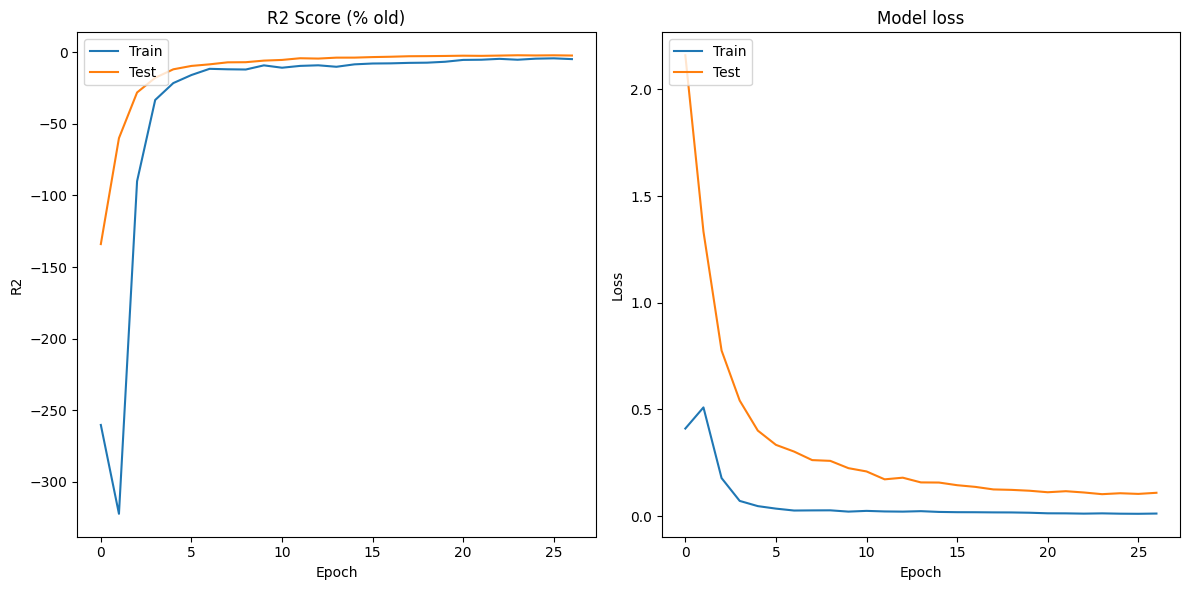

In [426]:
plot_history(history)

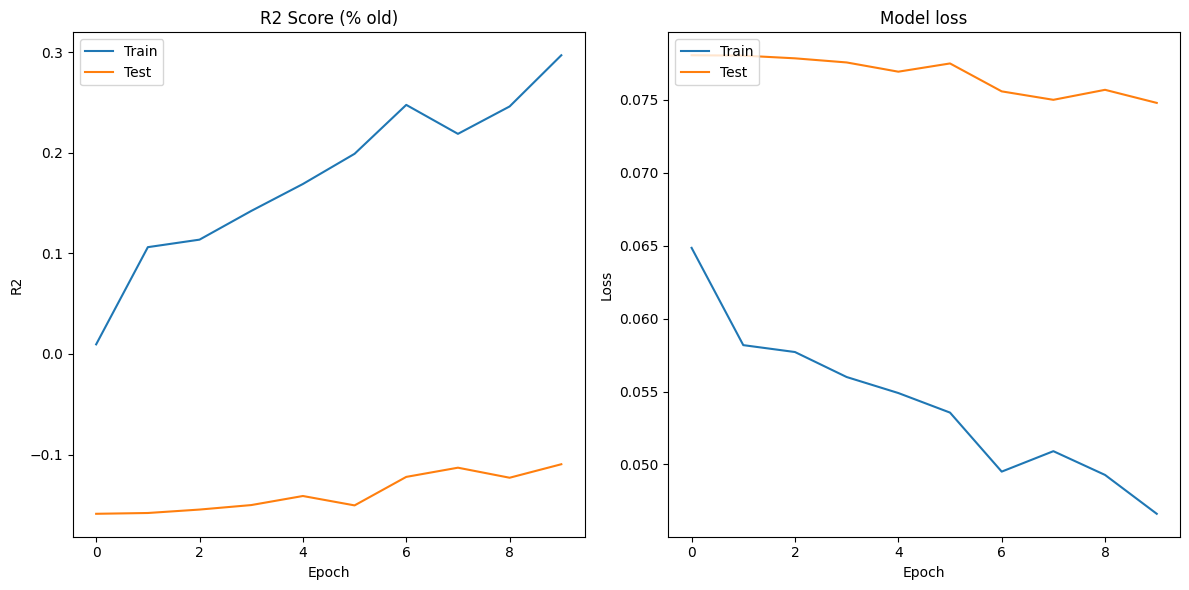

In [55]:
plot_history(history)